In [14]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

In [15]:
# df = pd.read_csv('data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
#                                                         , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
#                                                         , 'depth_error', 'mag_err'])
# df['timestamp'] = df.decimal_year.apply(timestamps.convert_decimal_year_to_numpy_datetime64)

df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

In [16]:
# df[(df.decimal_year > 2011) & (df.mag >= 6.5) & (df.depth <= 40) & (df.lon.between(142, 143))]

In [17]:
noto_hanto = {'coordinates':(136.686000, 37.220667), 'time':'2007-03-25 00:41:57.909996', 'tz':'UTC', 'magnitude':6.9}
western_tottori = {'coordinates':(133.349, 35.274167), 'time':'2000-10-06 04:30:17.940011', 'tz':'UTC', 'magnitude':6.7}
sugura_bay = {'coordinates':(138.499333, 34.786167), 'time':'2009-08-10 20:07:05.740017', 'tz':'UTC', 'magnitude':6.5}
iwaki = {'coordinates':(140.672667, 36.945667), 'time':'2011-04-11 08:16:12.020008', 'tz':'UTC', 'magnitude':6.6}
iwate_miyage = {'coordinates':(140.880667, 39.029833), 'time':'2008-06-13 23:43:45.359992', 'tz':'UTC', 'magnitude':6.8}
kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
tohoku = {'coordinates':(142.861000, 38.103500), 'time':'2011-03-11 05:46:18.119983', 'tz':'UTC', 'magnitude':9.0}

def plot_earthquake_on_basemap(eq, m, ax, **kwargs):
    x, y = m(eq['coordinates'][0], eq['coordinates'][1])
    ax.scatter(x, y, s=0.75*np.exp(eq['magnitude']), **kwargs)
    ax.annotate('{year} M{mag}'.format(year=np.datetime64(eq['time']).astype('datetime64[Y]').astype(str)
                                              , mag=str(eq['magnitude']))
                , xy=(x, y), xytext=(x, y+0.5), fontsize=15, color='red', fontweight='bold')

# noto_hanto

In [18]:
eq = noto_hanto

In [19]:
df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=75, m=1)

(<matplotlib.figure.Figure at 0x7fb4dca5b208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb4dca52860>)

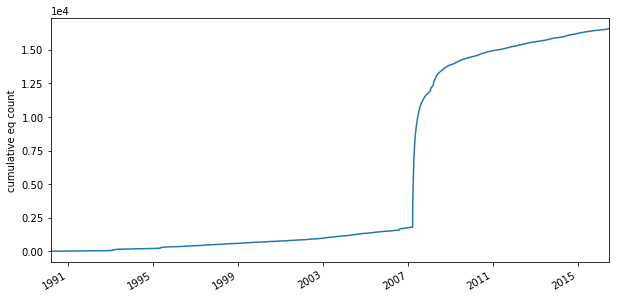

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_seismicity_rate(dataframe=df_regional[df_regional.mag>=0.5], fig=fig, ax=ax)

In [21]:
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=50]
df_regional = df_regional[df_regional.mag >= 0.5]

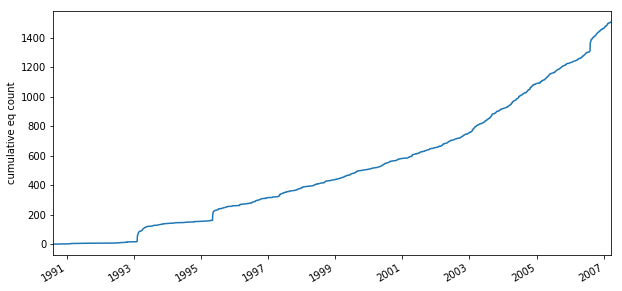

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
plotting.plot_seismicity_rate(dataframe=df_regional, fig=fig, ax=ax)
# ax.text(s='dfgdfg', x=2003, y=1000)
fig.savefig('sugura_bay_seismicity_cnt.png', dpi=300, bbox_inches='tight')

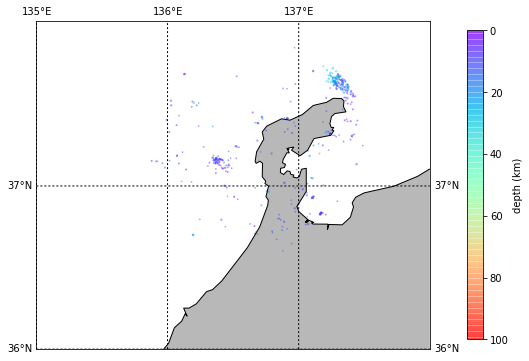

In [23]:
m, fig, ax = plotting.plot_seismicity_map(dataframe=df_regional[df_regional.mag>2])

(0, 50)

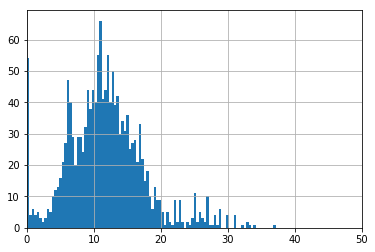

In [24]:
ax = df_regional.depth.hist(bins=100)
ax.set_xlim(0,50)

In [25]:
stats.calc_fmd_stats_with_mc(df_regional.mag)

(3.5603550018848713,
 0.48603601634866422,
 1.1853921889224968e-15,
 1061,
 1.1000000000000001)

In [26]:
radii = np.arange(1, 51, 1)
foreshock_time = eq['time']

timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
parameters = [x for x in product(radii, timii)]
df_regional = df_regional.loc[df_regional.index < foreshock_time]
# df_regional = df_regional[df_regional.mag >= 0.5]
# df_regional = df_regional[df_regional.depth <= 25]
n_iterations = 100

bdf = stats.calculate_b_value_parameter_sweep(dataframe=df_regional
                                              ,location=eq['coordinates']
                                              ,n_iterations=n_iterations
                                              ,parameters=parameters)

/home/max/pymap3/utilities/stats.py:45: RuntimeWarning: invalid value encountered in true_divide
  b_stddev = square_every_value((magnitudes - average).sum()) / (length * (length - 1))


/home/max/anaconda2/envs/research/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


(0, 50)

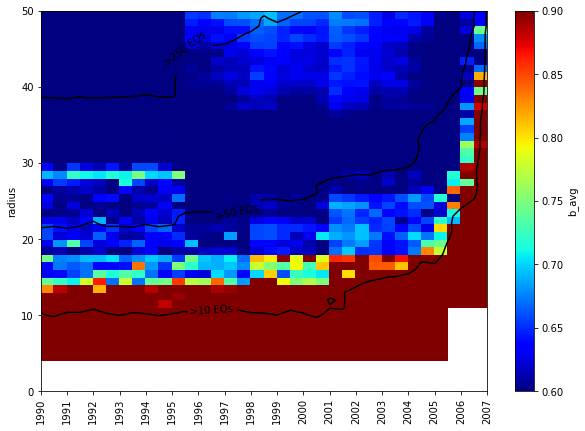

In [27]:
fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='b_avg',vmin=0.6, vmax=0.9, cmap='jet', fig=fig, ax=ax)

zi = bdf.pivot(index='start_time', columns='radius', values='n_avg')
xi_label = [np.datetime64(z, 'Y') for z in zi.index]
xi = np.arange(len(xi_label))
yi = zi.columns
xi, yi = np.meshgrid(xi, yi)

zi = np.ma.masked_invalid(zi).transpose()

levels = [10, 50, 250, 1000, 5000]
cs = ax.contour(xi,yi,zi, levels, colors='black')#, locator=ticker.LogLocator())

cs.levels = ['>10 EQs', '>50 EQs','>250 EQs', '>1000 EQs', '>5000 EQs']

ax.clabel(cs, cs.levels, inline=True)
ax.set_ylim(0,50)


# fig.savefig('noto_hanto_parameter.png', dpi=300, bbox_inches='tight', transparency=True)

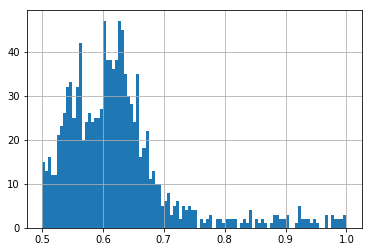

In [28]:
bdf.b_avg.hist(bins=100, range=(0.5, 1.))

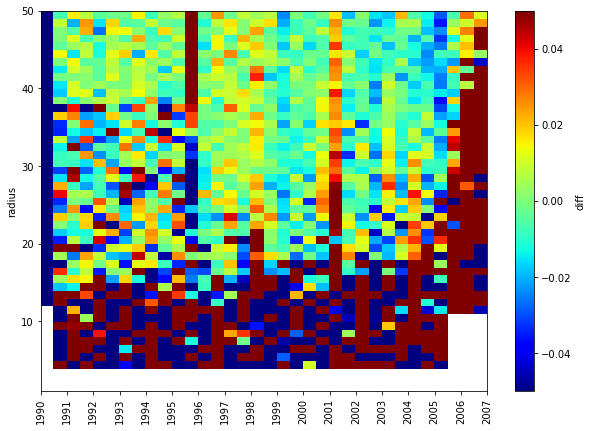

In [29]:
bdf['diff'] = bdf.b_avg.diff()

fig, ax = plt.subplots(figsize=(10,7))

fig, ax = plotting.plot_radius_time_sweep(dataframe=bdf, vertical_axis='radius'
                                 , value='diff',vmin=-0.05, vmax=0.05, cmap='jet', fig=fig, ax=ax)

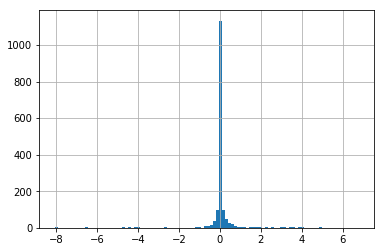

In [30]:
bdf['diff'].hist(bins=100,)

In [31]:
test = pd.DataFrame(columns=['a','b'])
test.apply(lambda x: x['a'] + 1)

,a,b


In [32]:
bdf.describe()

,radius,a_avg,b_avg,bstd_avg,n_avg,mc_avg,a_std,b_std,bstd_std,n_std,mc_std,diff
count,1750.000000,1617.000000,1617.000000,1.608000e+03,1617.000000,1617.000000,1.617000e+03,1.617000e+03,1.608000e+03,1617.000000,1617.000000,1609.000000
mean,25.500000,3.406897,1.110973,5.249073e-16,91.012460,1.177319,1.823702e+00,7.531202e-01,8.813140e-16,22.161941,0.288386,0.006579
std,14.434995,1.931531,1.194845,5.882317e-16,97.142408,0.149169,2.667455e+00,1.092875e+00,1.653045e-15,21.130119,0.131779,1.064903
min,1.000000,1.860112,0.462126,0.000000e+00,1.000000,0.767816,1.075288e-14,5.376441e-15,0.000000e+00,0.000000,0.000000,-8.078092
25%,13.000000,2.445159,0.571948,2.493592e-16,12.920000,1.100000,1.129873e-01,6.482615e-02,2.358749e-16,5.073709,0.184774,-0.016570
50%,25.500000,2.868479,0.631855,3.683791e-16,50.370000,1.156000,2.800259e-01,1.417056e-01,3.802223e-16,13.916704,0.252621,0.000612
75%,38.000000,3.171709,0.975343,5.596862e-16,140.710000,1.241000,3.296480e+00,1.165182e+00,5.635500e-16,34.242703,0.359152,0.026545
max,50.000000,17.371779,8.685890,5.839417e-15,385.170000,1.707000,9.733067e+00,3.859067e+00,1.648371e-14,87.003249,0.670651,6.785444
